In [1]:
import warnings
warnings.filterwarnings('ignore')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [4]:
train_dir='C:/Users/arkja/OneDrive/Desktop/SIH Jupyter code/train'
test_dir='C:/Users/arkja/OneDrive/Desktop/SIH Jupyter code/test'
valid_dir='C:/Users/arkja/OneDrive/Desktop/SIH Jupyter code/valid'

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
img_height, img_width = 224, 224  # ResNet50V2 expects 224x224 images

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',shuffle=True
)

# Testing data generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


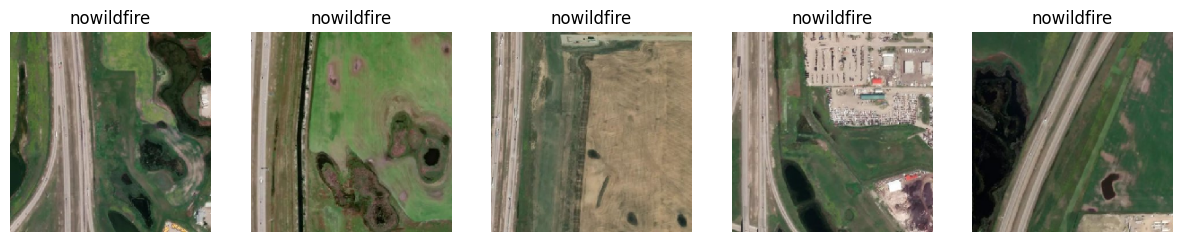

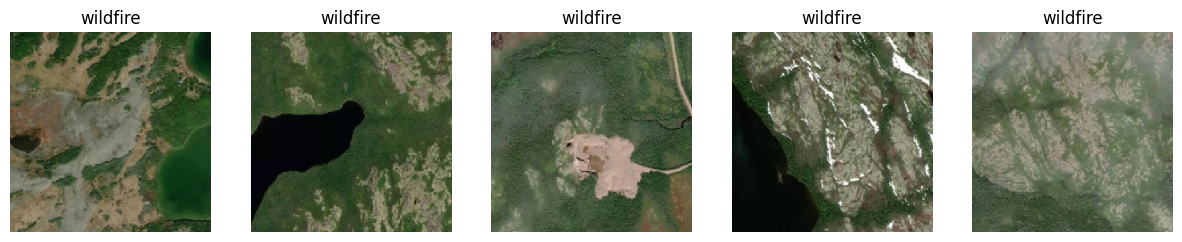

In [6]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Plotting 5 fire and 5 nofire images
plot_images(train_dir, 'nowildfire', 5)
plot_images(train_dir, 'wildfire', 5)

In [7]:
base_model = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 56, 56, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 56, 56, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 58, 58, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,781,825 (94.54 MB)

 Trainable params: 4,631,297 (17.67 MB)

 Non-trainable params: 20,150,528 (76.87 MB)

In [8]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    show_trainable=True
)

In [9]:
class PlotPredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_generator):
        self.valid_generator = valid_generator

    def on_epoch_end(self, epoch, logs=None):
        # Select a random image from the validation set
        valid_images, valid_labels = next(self.valid_generator)
        idx = np.random.randint(valid_images.shape[0])
        image = valid_images[idx]
        true_label = valid_labels[idx]

        # Predict the label
        prediction = self.model.predict(np.expand_dims(image, axis=0))[0][0]
        predicted_label = 'Fire' if prediction >= 0.5 else 'No Fire'
        true_label_text = 'Fire' if true_label == 1 else 'No Fire'

        # Plot the image with true and predicted labels
        plt.imshow(image)
        plt.title(f'True: {true_label_text}, Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

In [5]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

plot_predictions = PlotPredictionsCallback(valid_generator)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_scheduler, plot_predictions]
)

NameError: name 'PlotPredictionsCallback' is not defined

In [14]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

plot_predictions = PlotPredictionsCallback(valid_generator)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_scheduler, plot_predictions]
)

NameError: name 'valid_generator' is not defined

In [7]:
from callbacks import PlotPredictionsCallback


ModuleNotFoundError: No module named 'callbacks'

In [12]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotPredictionsCallback(Callback):
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.x_test)
        plt.figure()
        plt.plot(self.y_test, label='True values')
        plt.plot(predictions, label='Predicted values')
        plt.title(f'Epoch {epoch}')
        plt.legend()
        plt.show()


In [13]:
from callbacks import PlotPredictionsCallback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

plot_predictions = PlotPredictionsCallback(valid_generator)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_scheduler, plot_predictions]
)

ImportError: cannot import name 'PlotPredictionsCallback' from 'callbacks' (C:\Users\arkja\AppData\Local\Programs\Python\Python310\lib\site-packages\callbacks\__init__.py)